In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc


font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/H2HDRM.TTF').get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False  # matplotlib 에 한국어 폰트 적용

# 데이터 불러오기
data = pd.read_csv('weather_data.csv', encoding='cp949')


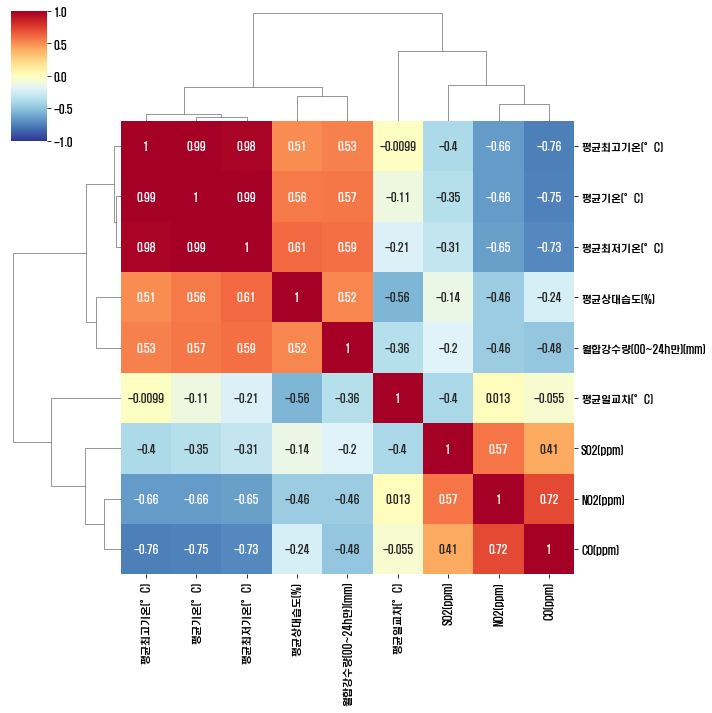

In [2]:
# 변수간 상관관계 분석
data_corr = data.iloc[:, 5:14].corr()  # 간단히 상관관계 구하기

# 기본적인 상관관계 그래프
sns.clustermap(data_corr,
               annot=True,  # 실제 값 화면에 나타내기
               cmap='RdYlBu_r',  # Red, Yellow, Blue 로 색상 표시
               vmin=-1, vmax=1  # 컬러차트 -1 ~ 1 범위로 표시
               )


<ipython-input-3-5d127f969d9b>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data_corr, dtype=np.bool)


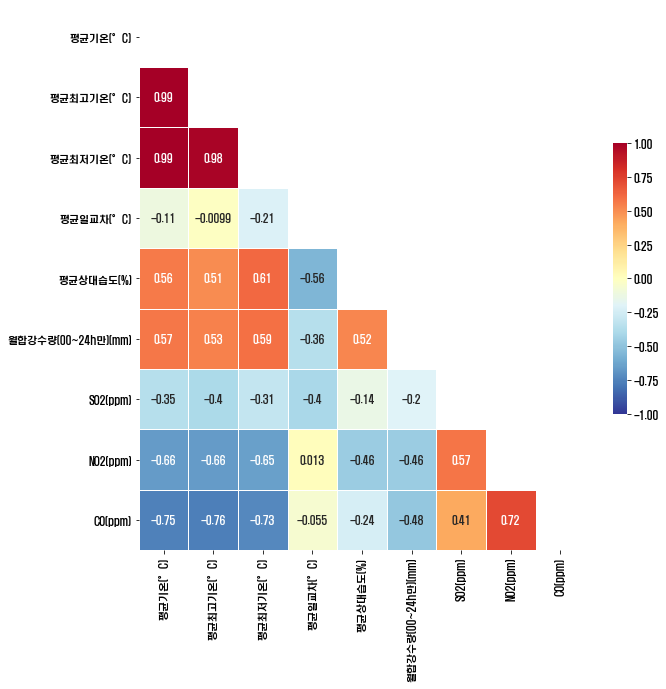

In [3]:
# 삼각형으로 상관관계 그리기
# 그림 사이즈 지정
fig, ax = plt.subplots(figsize=(10, 10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data_corr,
            cmap='RdYlBu_r',
            annot=True,  # 실제 값을 표시한다
            mask=mask,  # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},  # 컬러바 크기 절반으로 줄이기
            vmin=-1, vmax=1  # 컬러바 범위 -1 ~ 1
            )
plt.show()


<AxesSubplot:>

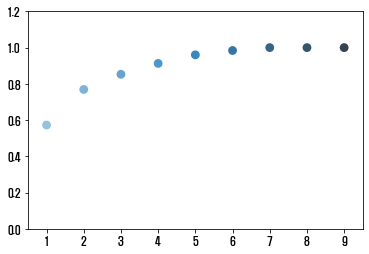

In [4]:
# 주성분 분석 해보기

# 정규화 시키기
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(data.iloc[:, 5:14])

# 주성분 분석 (PCA)
from sklearn.decomposition import PCA

# 그래프로 표현해보기
pca = PCA()
pca.fit(x)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
exp_var_cumul2 = pd.DataFrame(exp_var_cumul, index=range(1, exp_var_cumul.shape[0] + 1))

plt.ylim(0, 1.2)
sns.pointplot(data=exp_var_cumul2.T, palette='Blues_d')


In [5]:
# 주성분 데이터 셋 만들기
pca = PCA(n_components=2)  # PCA 객체 생성 (2개)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents,
                           columns=['principalComponents1', 'principalComponents2'])  # 2개의 주성분이 나타내는 값

# 2개의 인자들이 얼마만큼 변수를 설명 가능한지
print(pca.explained_variance_ratio_)

# 누적 값
print(sum(pca.explained_variance_ratio_))

# 주성분 분석이나 요인분석은 python 보다는 R이 더 직관적이고 사용이 편리한 것 같다.


[0.57263828 0.19634963]
0.7689879112079496


In [6]:
# 지역별 날씨 변화 그래프로 그려보기
import datetime

data['date'] = [datetime.datetime.strptime(str(i), '%Y%m') for i in data['날짜']]

<AxesSubplot:xlabel='date', ylabel='평균기온(°C)'>

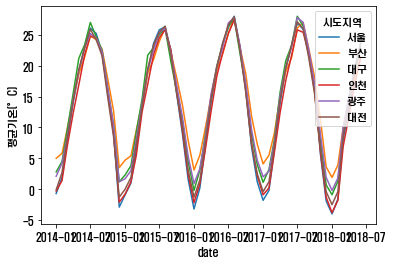

In [7]:
# 평균기온
sns.lineplot(x='date', y=data.columns[5], data=data, hue='시도지역')

<AxesSubplot:xlabel='date', ylabel='평균일교차(°C)'>

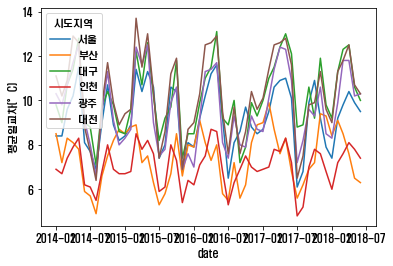

In [8]:
# 평균일교차
sns.lineplot(x='date', y=data.columns[8], data=data, hue='시도지역')

<AxesSubplot:xlabel='date', ylabel='평균상대습도(%)'>

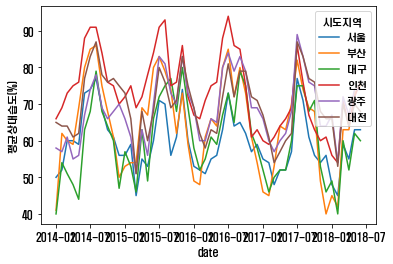

In [9]:
# 평균상대습도
sns.lineplot(x='date', y=data.columns[9], data=data, hue='시도지역')



In [ ]:
# 환경요인들로 회귀분석 해보기

# x요인들과 y값 그리고 교호작용만 갖는 데이터 셋 만들기

principalDf['pr1*pr2'] = principalDf['principalComponents1'] * principalDf['principalComponents2']

regression_d = pd.concat([principalDf, data['시도지역'], data['발생건수(건)']], axis=1)
regression_data = pd.get_dummies(regression_d)

x_var = regression_data.iloc[:, [0, 1, 2, 4, 5, 6, 7, 8, 9]]
y_var = pd.DataFrame(regression_data.iloc[:, 3])
y_var = regression_data.iloc[:, 3]
# 학습 검증데이터 분할
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_var, y_var, train_size=0.7, test_size=0.3, random_state=1)

import statsmodels.api as sm

regression_model = sm.OLS(y_var, x_var)
regression_fit_model = regression_model.fit()
regression_fit_model.summary()

# 다중공선성 확인 하기
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_var.values, i) for i in range(x_var.shape[1])]
vif["features"] = x_var.columns
print(vif)


# MSE 확인하기
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true=test_y['발생건수(건)'], y_pred=regression_fit_model.predict(test_x))

# 예측값과 차이 알아보기 test = pd.concat([test_y['발생건수(건)'], regression_fit_model.predict(test_x)], axis=1)

# 다른 방법으로 예측해보기

# 1. random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV  # gridsearch : 내가 지정한 몇가지 파라미터에서 최적의 파라미터를 찾아줌

estimator = RandomForestRegressor(random_state=486)
estimator.get_params().keys()  # 랜덤 포레스트의 파라미터들

param_grid = {'n_estimators' : range(5, 50),  # 보통 10개 내외, 높은수록 시간 오래 걸림
              'min_samples_split' : [6, 8 , 10, 12, 14],
              # 노드를 분할하기 위한 최소한의 샘플 데이터 수, 과적합을 제어하는데 사용, 디폴트 2, 작게 설정할 수록 과적합 가능성 증가
              'min_samples_leaf' : [8, 12, 16, 20],
              # 리프노드가 되기 위해 필요한 최소한의 샘플 데이터 수, 과적합 제어, 불균형 데이터의 경우 작게 설정 필요
              'max_depth' : [4, 6, 8, 10, 12]  # 트리의 최대 깊이, 디폴트 none, 깊이 깊어지면 과적학 가능성 있음
              }

grid = GridSearchCV(estimator, param_grid=param_grid, cv=5, n_jobs=-1)
# cv = kfold, n_job = 쓰레드수?(정확하지 않음) -1이면 최대로 사용 컴퓨터 부하 심할수도
grid.fit(train_x, train_y)
print(grid.best_params_)  # best 파라미터 출력

# 랜덤 포레스트 모델 만들기
rf_model = RandomForestRegressor(n_estimators=17,
                                 max_depth=8,
                                 min_samples_split=6,
                                 min_samples_leaf=8,
                                 n_jobs=-1)  # 하이퍼 파라미터대로 설정
rf_model.fit(train_x, train_y)
pred1 = rf_model.predict(test_x)


# mse 측정
import math
mse_rf = mean_squared_error(y_true=test_y, y_pred=pred1)
mse_rf
math.sqrt(mse_rf)

# 실제값과 예측값 흐름 시각화 하기 (matplotlib 이용)
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.plot(np.arange(98), test['predict'], label='predict')
plt.plot(np.arange(98), test['발생건수(건)'], label='발생건수')
plt.legend()

# support vector machine 사용해보기

from sklearn.svm import LinearSVR

# 최적 파라미터 찾기
svm_model = LinearSVR(random_state=486)
svm_model.get_params().keys()  # svm의 파라미터들

param_grid_svm = {'C' : [1, 10, 100, 1000, 10000, 20000, 50000, 100000],
                  'epsilon' : [0.1, 0.5, 1, 1.25, 1.5, 1.75, 2]}

grid_svm = GridSearchCV(svm_model, param_grid = param_grid_svm, cv=5)
grid_svm.fit(train_x, train_y)
print(grid_svm.best_params_)  # best 파라미터 출력



svm_model = LinearSVR(C=50000, random_state=486, epsilon=1.75)
svm_model.fit(train_x, train_y)
pred_svm = svm_model.predict(test_x)

plt.plot(np.arange(98), pred_svm, label='predict')
plt.plot(np.arange(98), test['발생건수(건)'], label='발생건수')
plt.legend()  # 실제값과 비교해보기
